In [45]:
import math
import torch
import ntwrk
from ntwrk.bayesopt import BayesOpt, expected_improvement, max_mean

import gym
import sys
sys.path.append("../ntwrk/gym/")
import network_sim
import numpy as np
import matplotlib.pyplot as plt

In [46]:
env = gym.make("PccNs-v0")
env.reset()

History length: 10
Features: ['sent latency inflation', 'latency ratio', 'send ratio']
Getting min obs for ['sent latency inflation', 'latency ratio', 'send ratio']
Reward: 0.00, Ewma Reward: 0.00


/home/vagrant/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.])

## Let's Try Bayesian Optimization

In [47]:
env.senders[0].rate = env.senders[0].starting_rate

Get some starting data

In [48]:
rate = torch.tensor(env.senders[0].rate).unsqueeze(0)

In [49]:
rwrd = torch.tensor(env.step(rate)[1]).unsqueeze(0)

In [50]:
rwrd

tensor([1.4012])

In [51]:
bayes_opt = BayesOpt(rate, rwrd, normalize=True)

#### just need to peak into bayes_opt and make sure things are working

In [52]:
bayes_opt.train_x

tensor([0.2080])

In [53]:
bayes_opt.train_y

tensor([1.4012])

In [54]:
best_y = bayes_opt.train_y.max(0)[0]

In [55]:
bayes_opt.surrogate.eval()
bayes_opt.surrogate_lh.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [56]:
test_points = torch.arange(1, 1000).float().div(1000)
pred_dist = bayes_opt.surrogate_lh(bayes_opt.surrogate(test_points))

EI = ntwrk.bayesopt.expected_improvement(pred_dist, best_y)

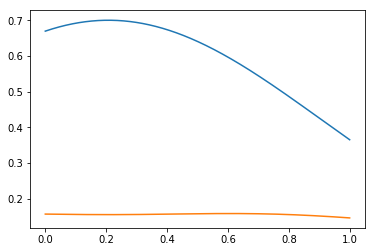

In [57]:
plt.plot(test_points, pred_dist.mean.detach())
plt.plot(test_points, EI.detach())
plt.show()

In [58]:
bayes_opt.train_surrogate()

In [59]:
bayes_opt.acquire()

tensor(0.8549)


tensor(854.8549)

### okay let's throw it in a loop

In [60]:
bo = BayesOpt(rate, rwrd, normalize=True, acquistion=expected_improvement)
env = gym.make("PccNs-v0")
env.reset()

History length: 10
Features: ['sent latency inflation', 'latency ratio', 'send ratio']
Getting min obs for ['sent latency inflation', 'latency ratio', 'send ratio']
Reward: 0.00, Ewma Reward: 0.00


/home/vagrant/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
       1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.])

set up phase

In [61]:
max_x = 1000
n_start = 3
rates = torch.rand(n_start)
rwrds = torch.zeros(n_start)
for rind, rr in enumerate(rates):
    rwrds[rind] = env.step(rr.unsqueeze(0).mul(max_x))[1].item()
    


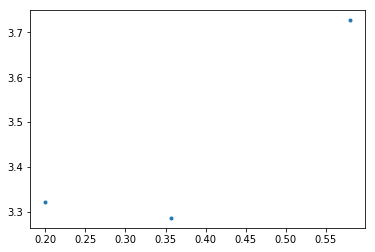

In [62]:
plt.plot(rates, rwrds, marker='.', linestyle="None")
plt.show()

In [67]:
rates.mul(max_x)

tensor([579.9888, 357.1467, 199.8425])

In [68]:
bo = BayesOpt(rates.mul(max_x), rwrds, normalize=True, max_x=max_x, acquistion=expected_improvement)

tensor(1.)
tensor([1000.])


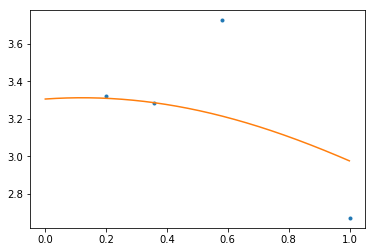

tensor(1.)
tensor([1000.])


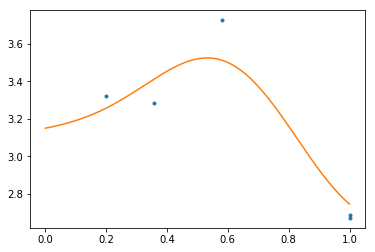

tensor(1.)
tensor([1000.])


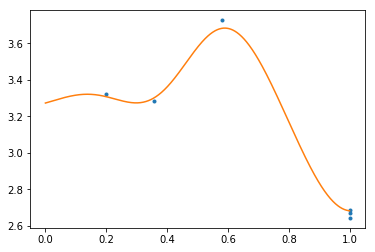

tensor(1.)
tensor([1000.])


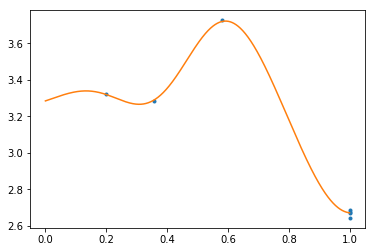

tensor(1.)
tensor([1000.])


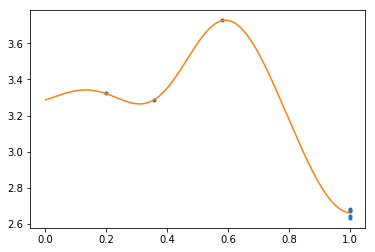

tensor(1.)
tensor([1000.])


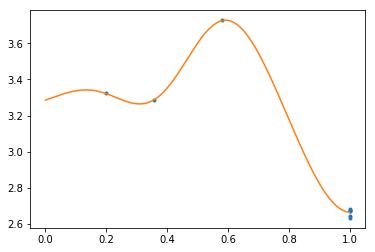

tensor(1.)
tensor([1000.])


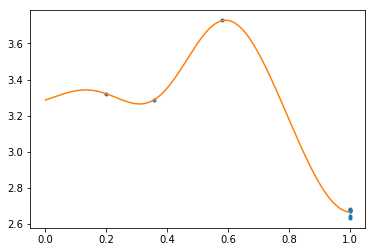

tensor(1.)
tensor([1000.])


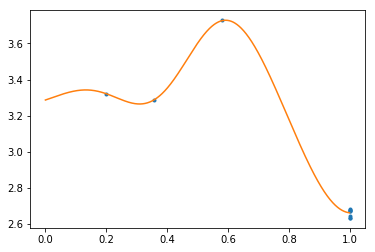

tensor(1.)
tensor([1000.])


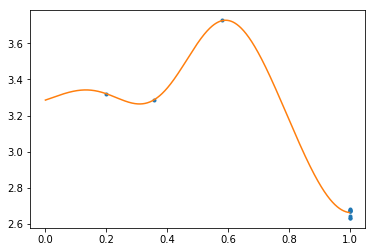

tensor(1.)
tensor([1000.])


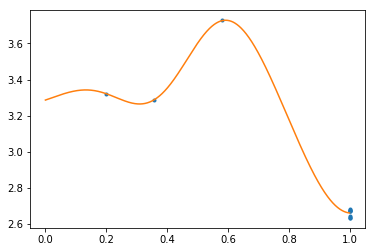

In [69]:
rnds = 10
test_points = torch.arange(1, 1000).float().div(max_x)
for ii in range(rnds):
    bo.train_surrogate(iters=200)
    next_rate = bo.acquire(explore=1.).unsqueeze(0)
    print(next_rate)
    rwrd = torch.tensor(env.step(next_rate.mul(bo.max_x))[1]).unsqueeze(0)

    bo.update_obs(next_rate, rwrd)
    test_dist = bo.surrogate_lh(bo.surrogate(test_points))
    
    plt.plot(bo.train_x, bo.train_y, marker='.', linestyle="None")
    plt.plot(test_points, test_dist.mean.detach())
    plt.show()